# [Understanding Image Patch Embeddings](https://medium.com/correll-lab/understanding-image-patch-embeddings-3d66c14fe7ed)

- https://npclinic3.tistory.com/6


트랜스포머 아키텍처가 강력한 이유는 텍스트, 이미지, 그 외의 어떤 데이터 및 그 조합을<br> 
구분하지 않기 때문입니다. “어텐션(Attention)” 모델은 시퀀스 내 모든 토큰 간의 자기 <br>
유사도(self-similarity)를 계산하여, 어떤 형태의 데이터든 요약하고 생성할 수 있게 합니다.<br> 
비전 트랜스포머(Vision Transformer)는 이미지를 정사각형 패치로 분할한 뒤, 이를 평탄화(flatten)하여 <br>
하나의 벡터 임베딩으로 만듭니다. 이렇게 되면 텍스트 임베딩(또는 다른 어떤 임베딩)과 똑같은 <br>
방식으로 처리할 수 있으며, 심지어 다른 데이터 타입과도 연결(concatenate)할 수 있습니다. <br>
종종 패치를 생성하는 단계는 첫 번째 학습 가능한 비선형 변환(learnable non-linear transformation)과 <br>
결합되는데, 이를 위해 2D 합성곱(convolution)을 사용하며, 이 부분은 이해하기가 쉽지 않습니다. <br>
본 글은 바로 이 단계에 대해 깊이 있게 탐구합니다. 또한, 여러분이 Colab 워크시트에 코드 조각을 <br>
그대로 복사해 붙여 넣어 따라 할 수 있도록 작성되었습니다. <br>

In [1]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch

torch.manual_seed(42)

img_size = (32,32) # We will resize MNIST images to this size
batch_size = 4

transform = T.Compose([
  T.ToTensor(),
  T.Resize(img_size)
])

train_set = MNIST(
  root="./../datasets", train=True, download=True, transform=transform
  )

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

batch = next(iter(train_loader)) # loads the first batch

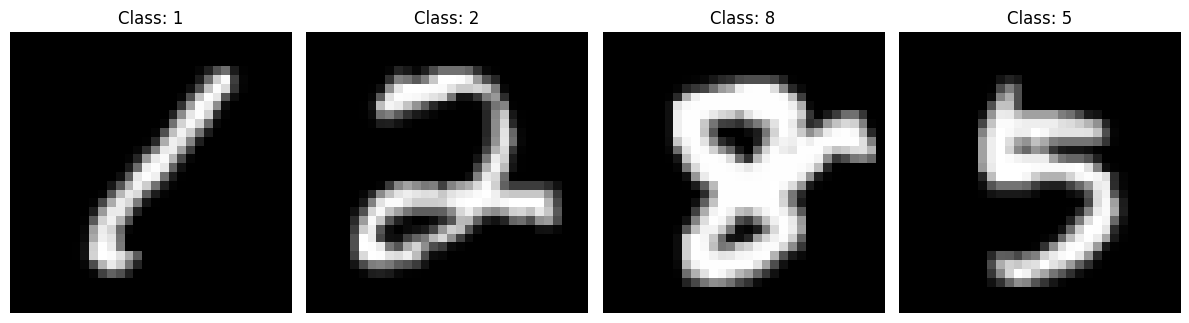

In [2]:
import matplotlib.pyplot as plt

# batch[0] contains the images and batch[1] the labels
images = batch[0]
labels = batch[1]

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, batch_size, figsize=(12, 4))

# Iterate through the batch of images and labels
for i in range(batch_size):
  # Convert the image tensor to a NumPy array and remove the channel dimension if it's a grayscale image
  image_np = images[i].numpy().squeeze()

  # Display the image in the corresponding subplot
  axes[i].imshow(image_np, cmap='gray')  # Use 'gray' cmap for grayscale images
  axes[i].set_title(f"Class: {labels[i].item()}") # Assuming labels are tensors, use .item() to get the value
  axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Creating Image Patches

Here is the code that breaks the image apart using Torch’ unfold operator:

In [3]:
import torch.nn as nn
# Image and patch sizes
img_size = (32, 32)
patch_size = (8, 8)
n_channels = 1

image = batch[0][1].unsqueeze(0)

# Patch Class
# class Patch(nn.Module):
#     def __init__(self, img_size, patch_size, n_channels):
#         super().__init__()
#         self.patch_size = patch_size
#         self.n_channels = n_channels

#     def forward(self, x): # B x C x H X W
#         x = x.unfold(
#             2, self.patch_size[0], self.patch_size[0]
#             ).unfold(
#                 3,self.patch_size[1],self.patch_size[1]
#                 )  # (B, C, P_row, P_col, P_height, P_width)
#         x = x.flatten(2)  #(B, C, P_row*P_col*P_height*P_width)
#         x = x.transpose(1, 2)  # (B,  P_row*P_col*P_height*P_width, C)
#         return x

# Instantiate model
#patch = Patch(img_size, patch_size, n_channels)

# Extract patches
# with torch.no_grad():
#     patches = patch(image) 

In [4]:
image.shape

torch.Size([1, 1, 32, 32])

In [5]:
x = image.clone()

In [6]:
x.shape

torch.Size([1, 1, 32, 32])

In [12]:
x1 = x.unfold(2, patch_size[0],patch_size[0])
x2 = x1.unfold(3, patch_size[1],patch_size[1])
x3 = x2.flatten(2)
x4 = x3.transpose(1,2)
patches = x4

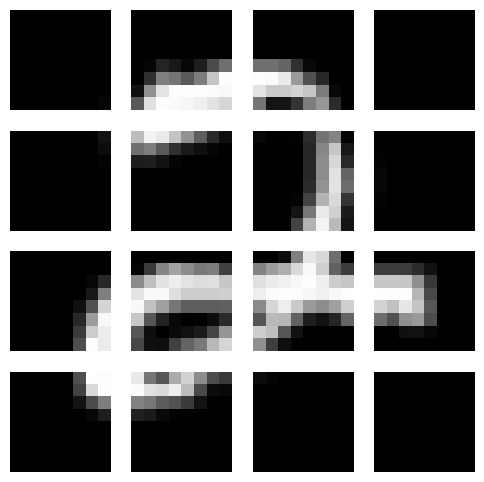

In [13]:
patches = patches.squeeze(0)  # Remove batch dimension -> (P, d_model)
patches = patches.view(-1, patch_size[0], patch_size[1]) # reshape back into 8x8

npatches = img_size[0] // patch_size[0]
# Plot patches
fig, axs = plt.subplots(npatches, npatches, figsize=(6, 6))  # 4x4 grid for (32x32) -> 16 patches

for i in range(npatches):
    for j in range(npatches):
        patch_idx = i * npatches + j  # Patch index
        axs[i, j].imshow(patches[patch_idx], cmap="gray", vmin=0, vmax=1)
        axs[i, j].axis("off")

plt.show()

## Creating Patch Embeddings
이 접근 방식은 임베딩의 차원을 원본 이미지 차원의 배수로 제한한다는 점을 눈치챘을 수도 있습니다.<br>
이 제한은 unfold 연산 뒤에 선형 투영(linear projection) 을 적용함으로써 바꿀 수 있으며, <br>
이렇게 하면 학습 가능한 임베딩을 만들 수 있습니다. <br>

![](../images/Patches.webp) 

Patches after a linear transformation with the identity matrix(left),<br>
after a linear transformation with random weights(middle), <br>
and a linear transformation with random weights and bias terms.  <br>

또한 이러한 임베딩은 시각화를 위해 다시 2D 텐서로 변환되었으며, 이를 통해 선형 투영이 패치 단위로<br>
어떻게 작동하는지 보여줍니다. `nn.Linear` 클래스를 `단위 행렬(identity matrix)`로 초기화하면 <br>
원본 데이터가 그대로 보존됨을 확인할 수 있습니다. 무작위 가중치(random weights)를 사용하면, 값이 0인 <br>
이미지 부분은 그대로 유지됨을 볼 수 있습니다. 마지막으로 bias 항을 추가하면 변환이 모든 패치에 동일하게 <br>
영향을 미친다는 사실을 알 수 있는데, 비어 있는 패치들이 모두 똑같은 bias 값을 갖는 것으로 나타납니다. <br>

이제 새롭게 정의된 클래스는 `PatchEmbedding`이라 불리며, 이를 인스턴스화하는 코드 한 줄도 함께 제시됩니다.<br>
여기서 새 변수` d_model`을 도입하는데, 이는 출력 임베딩의 원하는 차원을 의미합니다. 이제 이 값은 어떤 숫자든 <br> 
될 수 있습니다. 위의 그림에서는 `d_model=64`를 선택했지만, 더 이상 제한은 없습니다.<br>

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.d_model = d_model

        # Linear projection layer to map each patch to d_model
        self.linear_proj = nn.Linear(patch_size[0] * patch_size[1] * n_channels, d_model,bias=False)
        # The next two lines are unnecessary, but help to visualize that the linear 
        # projection operates along the correct dimensions
        #with torch.no_grad():
        #  self.linear_proj.weight.copy_(torch.eye(self.linear_proj.weight.shape[0]))
       
    def forward(self, x): # B x C x H X W

        x = x.unfold(
            2, self.patch_size[0], self.patch_size[0]
            ).unfold(
                3,self.patch_size[1],self.patch_size[1]
                )  # (B, C, P_row, P_col, P_height, P_width)
        
        B, C, P_row, P_col, P_height, P_width = x.shape
        x = x.reshape(B,C,P_row*P_col,P_height*P_width)
        x = self.linear_proj(x)  # (B*N, d_model)
  
        
        x = x.flatten(2)  #(B, C, P_row*P_col*P_height*P_width)
        x = x.transpose(1, 2)  # (B,  P_row*P_col*P_height*P_width, C)

        x = x.view(B, -1, self.d_model)
      
        return x

d_model = 64
# Instantiate model
patch = PatchEmbedding(img_size, patch_size, n_channels, d_model)

In [23]:
linear_proj = nn.Linear(patch_size[0] * patch_size[1] * n_channels, d_model,bias=False)

In [21]:
x = image.clone()
x1 = x.unfold(2, patch_size[0],patch_size[0])
x2 = x1.unfold(3, patch_size[1],patch_size[1])
B, C, P_row, P_col, P_height, P_width = x2.shape
print(f"B: {B}, C: {C}, P_row: {P_row}, P_col: {P_col}, P_height: {P_height}, \
        P_width: {P_width}")

B: 1, C: 1, P_row: 4, P_col: 4, P_height: 8,         P_width: 8


In [24]:
x3 = x2.reshape(B,C,P_row*P_col,P_height*P_width)
print(f"x3 shape: {x3.shape}")
x4 = linear_proj(x3)  # (B*N, d_model)
print(f"x4 shape: {x4.shape}")

x3 shape: torch.Size([1, 1, 16, 64])
x4 shape: torch.Size([1, 1, 16, 64])


In [26]:
x5 = x4.flatten(2)
print(f"x5 shape: {x5.shape}")
x6 = x5.transpose(1,2)
print(f"x6 shape: {x6.shape}")

x5 shape: torch.Size([1, 1, 1024])
x6 shape: torch.Size([1, 1024, 1])


In [27]:
x7 = x6.view(B, -1, d_model)
print(f"x7 shape: {x7.shape}")

x7 shape: torch.Size([1, 16, 64])


## Creating Patch Embeddings with the 2D convolution  
unfold 연산자는 꽤 번거롭고, 심지어 짜증스럽기까지 하다는 것을 눈치챘을 수도 있습니다. 이를 더 간단하게 처리할 방법이 있는데, 바로 원하는 패치 크기에 해당하는 커널 크기와 스트라이드 길이를 사용하여 **2D 합성곱(convolution)**을 수행하는 것입니다. 이렇게 하면 합성곱은 픽셀 단위가 아니라 패치 단위로 동작하게 되며, unfold와 nn.Linear를 조합했을 때와 동일한 결과를 얻을 수 있습니다. <br>

![](../images/conv2d_patches.webp)  

Using 2D Convoltuion to combine creating patches and linear transformation in a single step. 16x16 patches embedded into 4, 64 and 2500 dimensions(to row), and 8x8 patches embedded into 4, 64 and 2500 dimensions(bottom row).

This is the revised PatchEmbedding class:

In [28]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.d_model = d_model  # Flattened patch size

        # Conv2d to extract patches
        self.linear_project = nn.Conv2d(
            in_channels=n_channels,
            out_channels=self.d_model,  # Each patch is flattened to d_model
            kernel_size=patch_size,
            stride=patch_size,
            bias=False
        )

    def forward(self, x):
        x = self.linear_project(x)  # (B, d_model, P_row, P_col)
        x = x.flatten(2)  # (B, d_model, P_row * P_col) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, P, d_model)
        return x

위에서 만든 어떤 형태의 패치 임베딩이든 비전 트랜스포머(Vision Transformer)에 입력으로 사용할 수 있습니다. 이 과정을 **2D 합성곱(Conv2d)** 으로 구현하면 가장 범용적이고 간결한 표현 방식이 됩니다. 합성곱은 각 차원마다 전용 커널을 사용하지만, 지금까지는 모든 패치에 동일한 커널을 사용해왔다는 점을 주목하세요.

이를 그림으로 보여주고, 합성곱이 엉뚱한 동작을 하지 않는다는 것을 확인하기 위해, 커널 가중치를 초기화해서 각 커널이 패치당 단일 픽셀만 추출하도록 설정할 수 있습니다. 아래의 코드는 패치 크기가 (8,8)이고, 결과 임베딩 차원 `d_model=64`인 경우에 동작합니다. 이 코드를 PatchEmbedding 클래스의 `__init__` 메서드 마지막 부분에 추가하세요.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.d_model = d_model  # Flattened patch size

        # Conv2d to extract patches
        self.linear_project = nn.Conv2d(
            in_channels=n_channels,
            out_channels=self.d_model,  # Each patch is flattened to d_model
            kernel_size=patch_size,
            stride=patch_size,
            bias=False
        )

        """Initialize Conv2d to extract patches without transformation."""
        with torch.no_grad():
            identity_kernel = torch.zeros(
                self.d_model, self.n_channels, *self.patch_size
            )  # Shape: (64, 1, 8, 8)

            for i in range(self.d_model):  
                row = i // self.patch_size[1]  # Row index in the patch
                col = i % self.patch_size[1]   # Column index in the patch
                identity_kernel[i, 0, row, col] = 1  # Place a 1 at the correct pixel position

            self.linear_project.weight.copy_(identity_kernel)

    def forward(self, x):
        x = self.linear_project(x)  # (B, d_model, P_row, P_col)
        x = x.flatten(2)  # (B, d_model, P_row * P_col) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, P, d_model)
        return x

As you can see the identity_kernel tensor maintains d_model entries, one for each dimension, and only one pixel of each patch is set to one, thereby extracting just that pixel. A simpler way to do this is to simple cast a d_model x d_model identity matrix into d_model matrices of patch_size:

``` python
        identity_matrix = torch.eye(self.d_model)
        identity_kernel = identity_matrix.view(d_model, 1, *patch_size)  # Shape: (64, 1, 8, 8)

        with torch.no_grad():
             self.linear_project.weight.copy_(identity_kernel)
```